In [46]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix,roc_curve, auc, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import GridSearchCV
from dataprep.eda import create_report
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import LeavePGroupsOut
from sklearn.svm import SVC

# Functions

In [47]:
def train_test_split_per_user(data, train_size=0.8, target_column='label_negative_affect_category'):
    users = list(set(data.id))
    users = sorted(users, reverse=True)  # fix randomness
    total_users = len(users)
    slice_idx = int(train_size * total_users)
    users_train = users[:slice_idx]
    users_test = users[slice_idx:]
    
    # Split data based on user IDs
    train_data = data[data.id.isin(users_train)]
    test_data = data[data.id.isin(users_test)]
    
    x_train = train_data.drop(['id', target_column], axis=1) 
    y_train = train_data[target_column]  
    x_test = test_data.drop(['id', target_column], axis=1) 
    y_test = test_data[target_column]  
    
    return x_train, y_train, x_test, y_test

In [48]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

In [49]:
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
complementary_colors = ['#a9d0f5', '#f3ba8c', '#98e698', '#f5a9a9', '#d8b5d8', '#d2a6a6', '#f5a9f2', '#d8d8d8']

full_palette = custom_colors + complementary_colors
sns.set_palette(full_palette)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 15

In [50]:
df = pd.read_pickle('../data/lifesnaps/lifesnapsv2.pkl')
df['id'] = df['id'].astype(str)
df = df[df['label_stai_stress'].notna()]
df = df.drop(columns=['label_panas_negative_affect', 'label_stress_sema'])
df

,id,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,...,bmi,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos,label_stai_stress
298,621e335a67b776a240bb12ff,35.560128,62.3900,34.057,96.0,15.0,72.0,0.733333,0.700,0.700000,...,1,-0.866025,0.000000,0.587785,-2.449294e-16,0.5,1.000000,0.809017,1.000000,0
301,621e34db67b776a240c9c2be,34.847500,62.3900,34.057,96.0,15.0,72.0,0.733333,0.700,0.700000,...,1,-0.866025,0.000000,0.587785,-2.449294e-16,0.5,1.000000,0.809017,1.000000,1
302,621e30e467b776a240e817c7,33.274919,52.5365,38.161,94.5,17.2,72.0,0.733333,0.700,0.700000,...,3,-0.866025,0.000000,0.587785,-2.449294e-16,0.5,1.000000,0.809017,1.000000,2
305,621e32af67b776a24045b4cf,33.926363,56.3910,41.789,96.7,13.4,72.0,0.733333,0.700,0.666667,...,1,-0.866025,0.000000,0.587785,-2.449294e-16,0.5,1.000000,0.809017,1.000000,2
310,621e2fce67b776a240279baa,34.379283,73.5040,21.036,98.0,15.2,72.0,0.733333,0.700,0.666667,...,1,-0.866025,0.000000,0.587785,-2.449294e-16,0.5,1.000000,0.809017,1.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,621e346f67b776a24081744f,33.933047,72.3240,26.077,96.0,18.8,72.0,0.733333,0.700,0.700000,...,3,0.866025,0.974928,0.587785,6.513725e-01,0.5,-0.222521,0.809017,-0.758758,1
4725,621e339967b776a240e502de,34.097435,51.6640,47.480,95.5,12.4,72.0,0.733333,0.725,0.700000,...,1,0.866025,0.974928,0.587785,6.513725e-01,0.5,-0.222521,0.809017,-0.758758,1
4870,621e2f9167b776a240011ccb,34.359505,59.2550,26.811,95.4,15.4,72.0,0.700000,0.700,0.766667,...,1,0.866025,-0.781831,0.587785,-1.011683e-01,0.5,0.623490,0.809017,-0.994869,2
4899,621e367e67b776a24087d75d,33.189233,54.6510,40.814,96.0,11.6,72.0,0.733333,0.700,0.700000,...,3,0.866025,0.000000,0.809017,-2.993631e-01,0.5,1.000000,0.587785,-0.954139,0


In [51]:
X = df.drop(['label_stai_stress', 'id'], axis=1)  # Features
y = df['label_stai_stress']  # Target variable
unique_labels = y.unique()
groups = df['id']  # Group identifier for LOPO

#model = RandomForestClassifier(n_estimators=100, random_state=42)
model = XGBClassifier(n_estimators=100)

cv = LeavePGroupsOut(n_groups=1)
scores = []
confusion_matrices = []

for train_idx, test_idx in cv.split(X, y, groups):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='macro')
    scores.append(score)
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    confusion_matrices.append(cm)

# Calculate the average performance across all LOPO iterations
average_score = np.mean(scores)
print(f'Average f1-scores across all LOPO iterations: {average_score}')
total_confusion_matrix = np.sum(confusion_matrices, axis=0)
print(total_confusion_matrix)

Average f1-scores across all LOPO iterations: 0.3102135809682979
[[41 40 21]
 [31 40 17]
 [30 21 26]]


In [22]:
df['label_stai_stress'].value_counts()

0    102
1     88
2     77
Name: label_stai_stress, dtype: int64

In [23]:
X_train, y_train, X_test, y_test = train_test_split_per_user(df,target_column='label_stai_stress')

In [24]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(199, 42) (199,) (68, 42) (68,)


In [25]:
# Initialize SMOTE
smote = SMOTE(random_state=42)
# Fit SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# Now X_train_smote and y_train_smote have balanced classes

In [26]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [27]:
clf.fit(X_train_smote, y_train_smote)
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='micro')
print(f"F1 Score: {f1}")
print(confusion_matrix(y_test, y_pred))

F1 Score: 0.29411764705882354
[[14 18  9]
 [ 4  3  2]
 [ 8  7  3]]


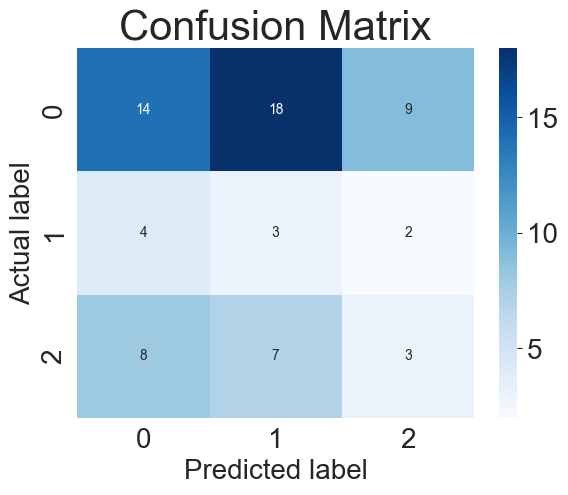

In [28]:
plot_confusion_matrix(y_test, y_pred)

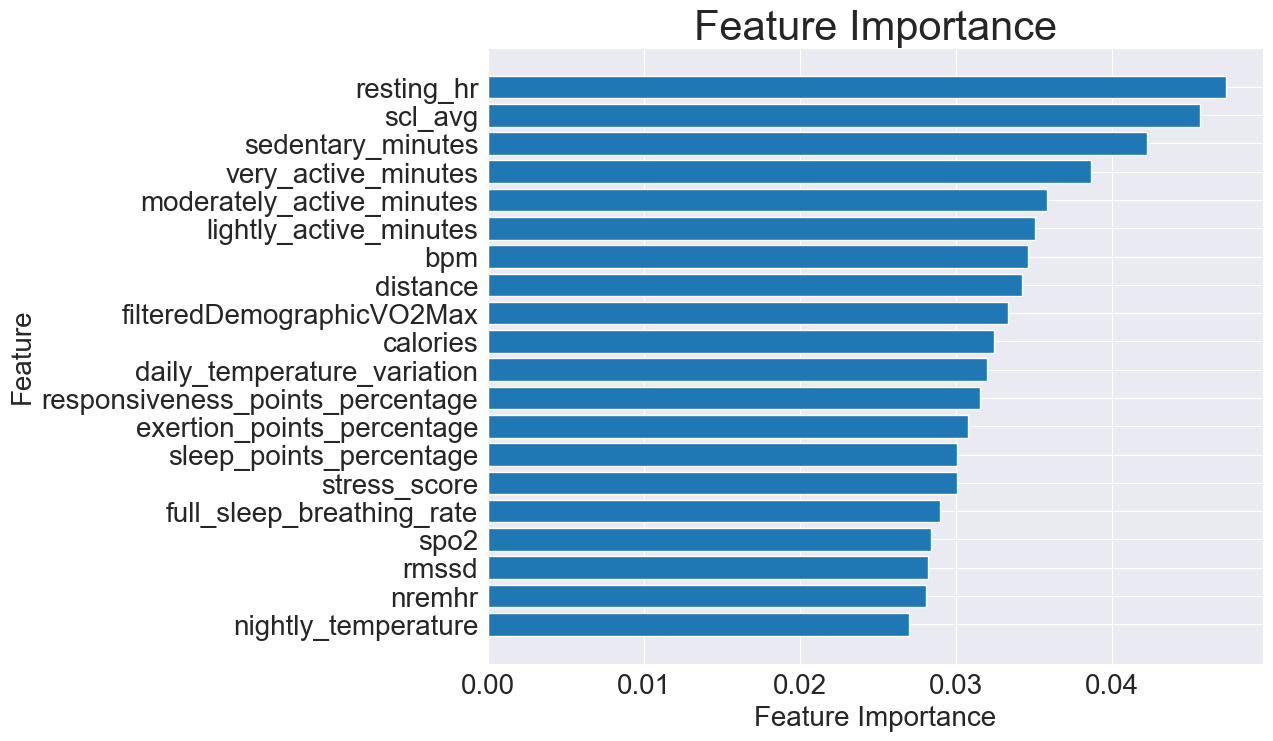

Index(['minutes_below_default_zone_1', 'bpm', 'calories', 'sleep_rem_ratio',
       'sedentary_minutes', 'minutes_in_default_zone_1',
       'moderately_active_minutes', 'daily_temperature_variation',
       'minutesAwake', 'day_sin', 'nremhr', 'nightly_temperature',
       'sleep_deep_ratio', 'rmssd', 'sleep_wake_ratio', 'distance',
       'resting_hr', 'lightly_active_minutes', 'steps',
       'filteredDemographicVO2Max'],
      dtype='object')


In [29]:
feature_importances = clf.feature_importances_
sorted_idx = np.argsort(feature_importances)[-20:]
sorted_importances = feature_importances[sorted_idx]

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), [X_train.columns[i] for i in range(len(sorted_idx))])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

print(X_train.columns[sorted_idx])

# ROC AUC curve
First, we need to predict class probabilities rather than class labels for the test set. This is because the ROC curve requires probabilities to compute the true positive rate and false positive rate at various thresholds.

In [30]:
y_prob = clf.predict_proba(X_test)  # matrix of probabilities

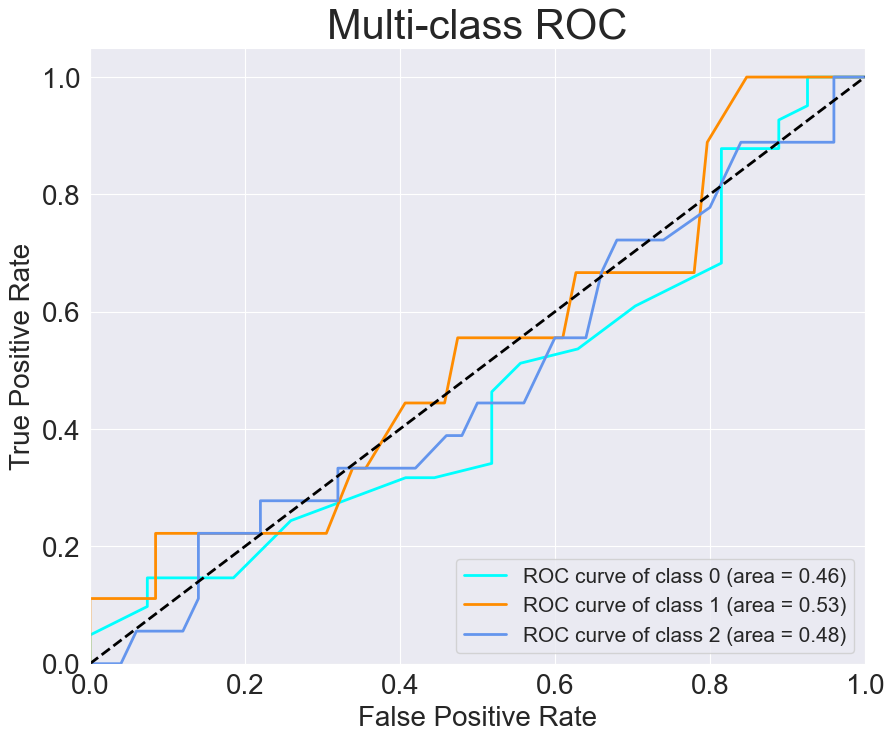

In [31]:
# Binarize the output labels for multi-class ROC AUC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting
plt.figure(figsize=(10, 8))
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()